In [2]:
!nvidia-smi

Sun Mar 30 00:47:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
# Clear TensorFlow backend session to avoid reusing old models
tf.keras.backend.clear_session()
# Set Up MirroredStrategy for GPU parallelism
strategy = tf.distribute.MirroredStrategy()

In [5]:
# Load Dataset (assuming CSV with columns 'Content' and 'Category')
df = pd.read_csv('/kaggle/input/111111/Classification.csv')  # Replace with the actual path to your dataset
# Shuffle the dataset
df = df.sample(frac=1, random_state=77).reset_index(drop=True)
# df = df.sample(n=30000, random_state=42)
df

,Content,Category
0,प्रतिनिधि सभाका सदस्यहरूलाई विषयगत समितिमा हेर...,politics
1,काठमाण्डाै कृषि पशुपक्षी विकास मन्त्रालयको प्र...,society
2,आहा रारा गोल्डकपको फाइनलमा भुटानी युथ स्पोर्ट्...,sports
3,काठमाडौं नेकपा एमालेका सांसद योगेश भट्टराईले व...,health
4,काठमाडौं संघीय संसदको आगामी अधिवेशनमा बिजनेसको...,politics
...,...,...
70575,नुवाकोट धान दिवसका अवसरमा नुवाकोटका किसानले ने...,society
70576,नेपाली कांग्रेसको महाधिवेशनअन्तर्गत नेतृत्वका ...,politics
70577,एजेन्सी भारतको गुजरातमा चट्याङ लागेर जनाको मृत...,World
70578,दोलखा दोलखाको कालिञ्चोक गाउँपालिकामा छोराको कु...,society


In [6]:
nan_values = df.isna().sum()
nan_values

Content     2
Category    0
dtype: int64

In [7]:
# Remove rows with NaN values
df = df.dropna()

In [8]:
# Total count of non-NaN values in 'content' and 'category' columns
content_count = df['Content'].count()
category_count = df['Category'].count()

print(f"Total count of 'content': {content_count}")
print(f"Total count of 'category': {category_count}")

Total count of 'content': 70578
Total count of 'category': 70578


In [9]:
# @title
# Count the exact number of each category
category_counts = df['Category'].value_counts()
category_counts

Category
economy          11401
politics         11050
sports           10805
society           9355
World             8966
entertainment     6511
opinion           6240
health            3686
Education         2564
Name: count, dtype: int64

In [10]:
# Label Encoding
label_encoder = LabelEncoder()
df['Encoded_Category'] = label_encoder.fit_transform(df['Category'])
print("\nCategory Labels Mapping:")
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(category_mapping)
# Get encoded labels from the 'Encoded_Category' column of the DataFrame
encoded_labels = df['Encoded_Category'].values
num_classes = len(np.unique(encoded_labels))


Category Labels Mapping:
{'Education': 0, 'World': 1, 'economy': 2, 'entertainment': 3, 'health': 4, 'opinion': 5, 'politics': 6, 'society': 7, 'sports': 8}


<ipython-input-10-6015c157caa4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Encoded_Category'] = label_encoder.fit_transform(df['Category'])


In [11]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Define features (texts) and encoded labels
texts = df['Content'].tolist()  # Extract text data
labels = df['Encoded_Category'].tolist()  # Extract encoded labels

# First, split the data into training (80%) and temp (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.2, random_state=77, stratify=labels)

# Then, split temp set into validation (10%) and testing (10%) sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=77, stratify=y_temp)

# Convert splits into DataFrames
train_df = pd.DataFrame({'Content': X_train, 'Label': y_train})
val_df = pd.DataFrame({'Content': X_val, 'Label': y_val})
test_df = pd.DataFrame({'Content': X_test, 'Label': y_test})

# Print sizes of the resulting datasets
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 56462
Validation set size: 7058
Testing set size: 7058


In [12]:
from transformers import BertTokenizer
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

# Tokenization function
def tokenize_and_pad(texts, tokenizer, max_len=512):
    tokenized = tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',  # Pad to max length
        truncation=True,       # Truncate sequences longer than max_len
        return_tensors='tf'    # Return TensorFlow tensors
    )
    return tokenized['input_ids'], tokenized['attention_mask']

# Tokenize and pad datasets
train_input_ids, train_attention_masks = tokenize_and_pad(train_df['Content'].tolist(), tokenizer)
test_input_ids, test_attention_masks = tokenize_and_pad(test_df['Content'].tolist(), tokenizer)
val_input_ids, val_attention_masks = tokenize_and_pad(val_df['Content'].tolist(), tokenizer)

# Convert labels to tensors
train_labels = tf.convert_to_tensor(train_df['Label'].tolist())
test_labels = tf.convert_to_tensor(test_df['Label'].tolist())
val_labels = tf.convert_to_tensor(val_df['Label'].tolist())


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [13]:
# Define batch size
batch_size = 64

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({"input_ids": train_input_ids, "attention_mask": train_attention_masks}, train_labels)
).shuffle(len(train_input_ids)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ({"input_ids": test_input_ids, "attention_mask": test_attention_masks}, test_labels)
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    ({"input_ids": val_input_ids, "attention_mask": val_attention_masks}, val_labels)
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# # Build Model
# # Pass the Contextual Word Embeddings to the CNN-BiLSTM Model
# def build_cnn_bilstm_model_with_bert_embeddings(bert_model, num_classes):
#     input_ids = tf.keras.Input(shape=(512,), dtype=tf.int32, name='input_ids')
#     attention_mask = tf.keras.Input(shape=(512,), dtype=tf.int32, name='attention_mask')

#     bert_model.trainable = True
#     # Use BertEmbeddingLayer to get contextual embeddings
#     # bert_embeddings = BertEmbeddingLayer(bert_model)([input_ids, attention_mask])
#     bert_embeddings = bert_model.bert(input_ids, attention_mask = attention_mask)[0]

#     # CNN Layer
#     cnn1 = tf.keras.layers.Conv1D(filters=200, kernel_size=5, activation='relu', padding='same')(bert_embeddings)
#     # cnn2 = tf.keras.layers.Conv1D(filters=256, kernel_size=6, activation='relu', padding='same')(bert_embeddings)
#     # Concatenate outputs from different kernel sizes
#     # cnn_concat = tf.keras.layers.Concatenate()([cnn1,cnn2])
#     # Add Dropout
#     # cnn = tf.keras.layers.Dropout(0.1)(cnn_concat)
#     # BiLSTM Layer
#     lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True))(cnn1)
#      # Add Dropout
#     lstm = tf.keras.layers.Dropout(0.1)(lstm)
#     pooled_output = tf.keras.layers.GlobalMaxPooling1D()(lstm)
#     # Dense Layers
#     dense = tf.keras.layers.Dense(100, activation='relu')(pooled_output)
#     # dense = tf.keras.layers.Dropout(0.1)(dense)         # Add Dropout
#     output = tf.keras.layers.Dense(num_classes, activation='softmax')(dense)

#     # Build the model
#     model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

#     return model

In [14]:
# Build Model
# Pass the Contextual Word Embeddings to the CNN-BiLSTM Model
def build_cnn_bilstm_model_with_bert_embeddings(bert_model, num_classes):
    input_ids = tf.keras.Input(shape=(512,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(512,), dtype=tf.int32, name='attention_mask')
    
    bert_model.trainable = False
    # Use BertEmbeddingLayer to get contextual embeddings
    # bert_embeddings = BertEmbeddingLayer(bert_model)([input_ids, attention_mask])
    bert_embeddings = bert_model.bert(input_ids, attention_mask = attention_mask)[0]
    # BiLSTM Layer
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True))(bert_embeddings)
     # Add Dropout
    # lstm = tf.keras.layers.Dropout(0.1)(lstm)

    # CNN Layer
    cnn1 = tf.keras.layers.Conv1D(filters=100, kernel_size=3, activation='relu', padding='same')(lstm)
    cnn2 = tf.keras.layers.Conv1D(filters=100, kernel_size=5, activation='relu', padding='same')(lstm)
    # Concatenate outputs from different kernel sizes
    cnn_concat = tf.keras.layers.Concatenate()([cnn1,cnn2])
    # Add Dropout
    # cnn = tf.keras.layers.Dropout(0.1)(cnn_concat)

    pooled_output = tf.keras.layers.GlobalMaxPooling1D()(cnn_concat)
    # Dense Layers
    dense = tf.keras.layers.Dense(200, activation='relu')(pooled_output)
    # dense = tf.keras.layers.Dropout(0.1)(dense)         # Add Dropout
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(dense)

    # Build the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return model

In [19]:
# Use strategy.scope() for distributed training if needed
strategy = tf.distribute.get_strategy()
with strategy.scope():
    # Build and compile the model within the strategy scope
    model =build_cnn_bilstm_model_with_bert_embeddings(bert_model, num_classes)
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


In [20]:
# Train the Model
# # apply early stopping
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
# # # Train the model
# history = model.fit(train_dataset, epochs=20, validation_data=val_dataset,callbacks=[early_stopping])
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)

# Predictions and true labels
y_pred = model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred, axis=1)

# Evaluate the Model using the Dataset
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20
883/883 [==============================] - 1598s 2s/step - loss: 1.4319 - accuracy: 0.5667 - val_loss: 0.7547 - val_accuracy: 0.7584
Epoch 2/20
883/883 [==============================] - 1582s 2s/step - loss: 0.6526 - accuracy: 0.7915 - val_loss: 0.5876 - val_accuracy: 0.8033
Epoch 3/20
883/883 [==============================] - 1582s 2s/step - loss: 0.5495 - accuracy: 0.8199 - val_loss: 0.5285 - val_accuracy: 0.8246
Epoch 4/20
883/883 [==============================] - 1581s 2s/step - loss: 0.5125 - accuracy: 0.8311 - val_loss: 0.4924 - val_accuracy: 0.8313
Epoch 5/20
883/883 [==============================] - 1582s 2s/step - loss: 0.4861 - accuracy: 0.8394 - val_loss: 0.5013 - val_accuracy: 0.8342
Epoch 6/20
883/883 [==============================] - 1582s 2s/step - loss: 0.4690 - accuracy: 0.8449 - val_loss: 0.4573 - val_accuracy: 0.8443
Epoch 7/20
883/883 [==============================] - 1581s 2s/step - loss: 0.4557 - accuracy: 0.8483 - val_loss: 0.4366 - val_accuracy:

In [32]:
# model symmary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1778534   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                     

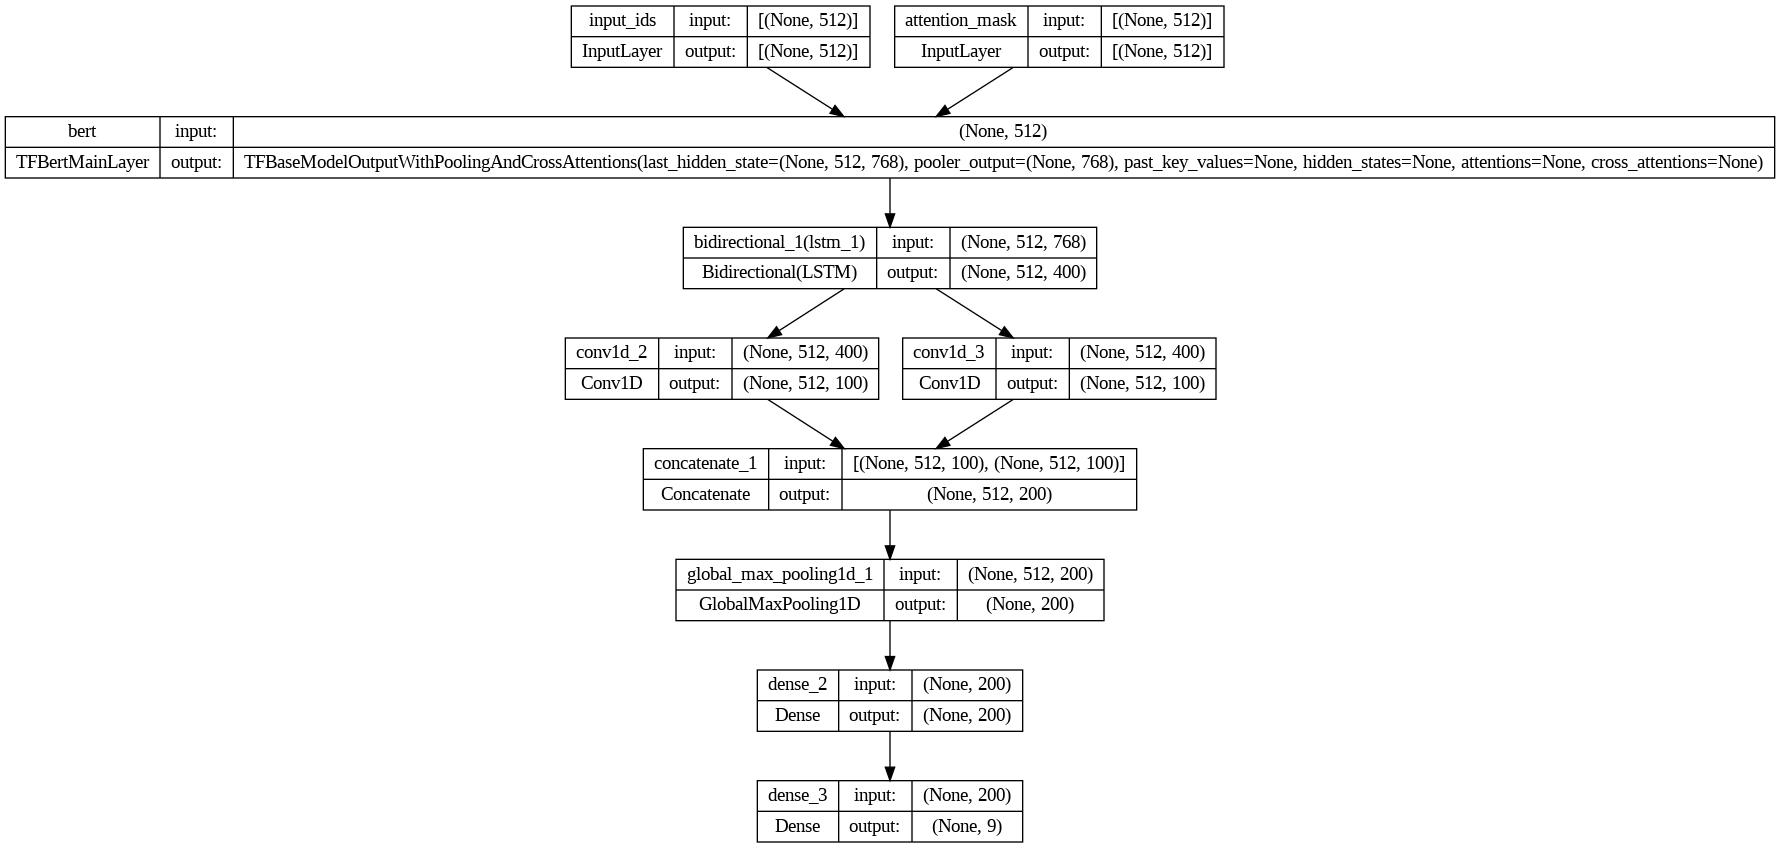

In [33]:
# Plot the model architecture and save to the specified file
tf.keras.utils.plot_model(model, to_file='BER-BiLSTM-CNN_model_architecture.png', show_shapes=True, show_layer_names=True)

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize # import the label_binarize function

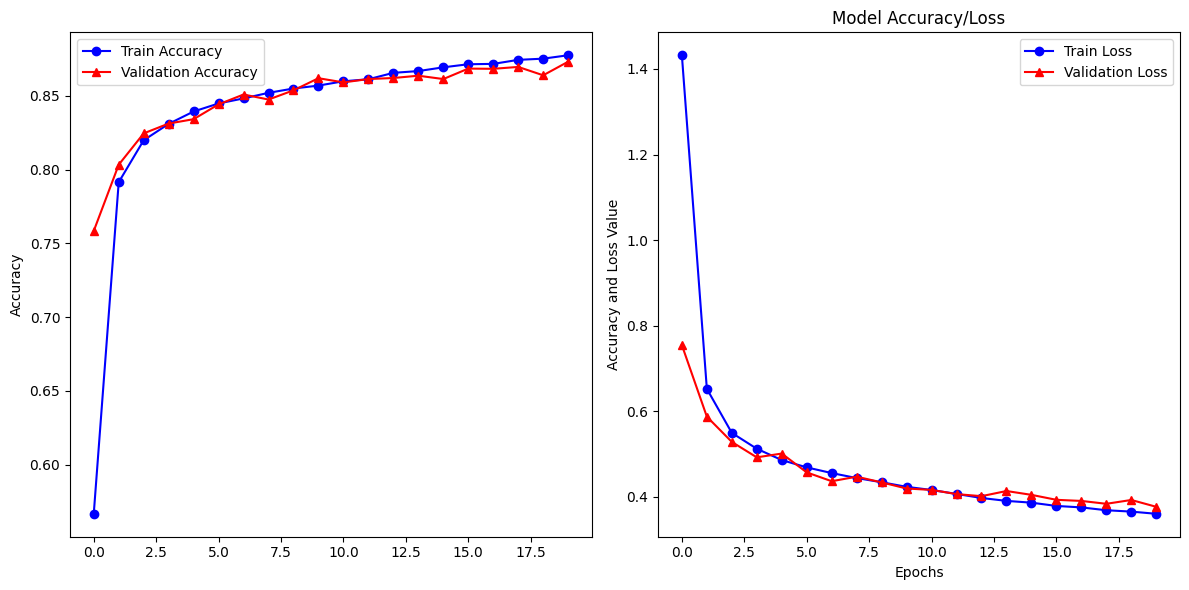

In [35]:
# Plot accuracy and loss curves
def plot_training_history(history):
    # Plot Accuracy
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'],'bo-', label='Train Accuracy')
    plt.plot(history.history['val_accuracy'],'r^-', label='Validation Accuracy')
    # plt.title('Accuracy')
    # plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'],'bo-',label='Train Loss')
    plt.plot(history.history['val_loss'], 'r^-',label='Validation Loss')
    plt.title('Model Accuracy/Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy and Loss Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)

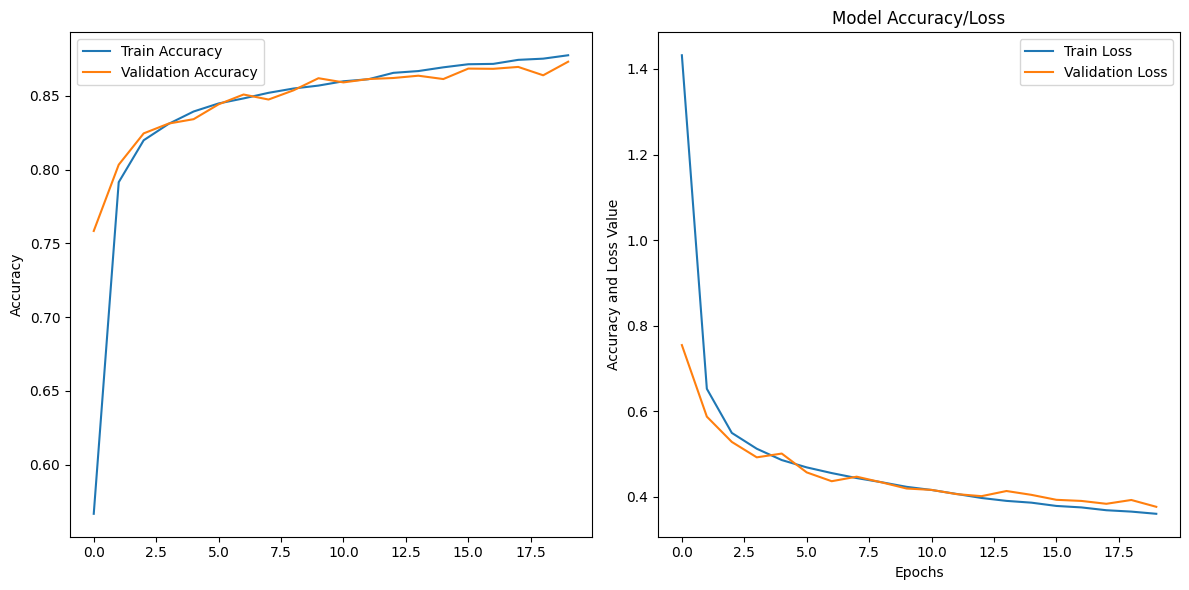

In [36]:
# Plot accuracy and loss curves
def plot_training_history(history):
    # Plot Accuracy
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    # plt.title('Accuracy')
    # plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'],label='Train Loss')
    plt.plot(history.history['val_loss'],label='Validation Loss')
    plt.title('Model Accuracy/Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy and Loss Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)

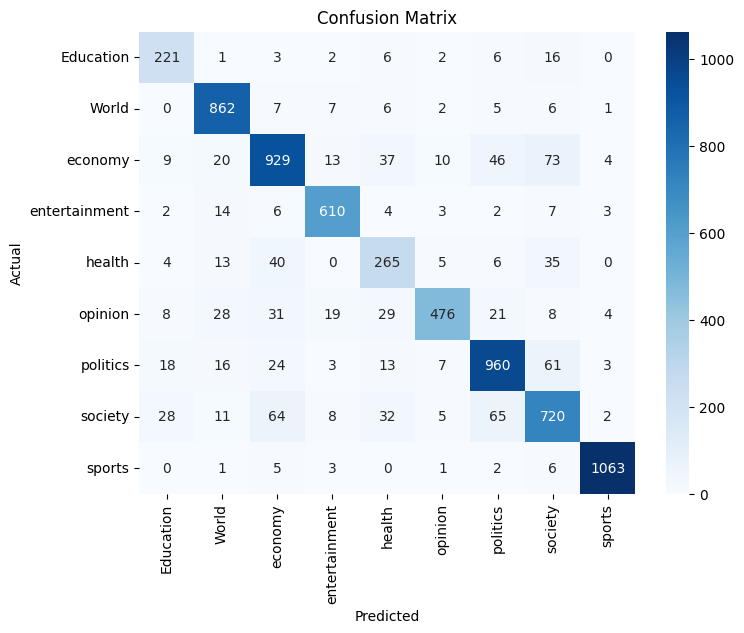

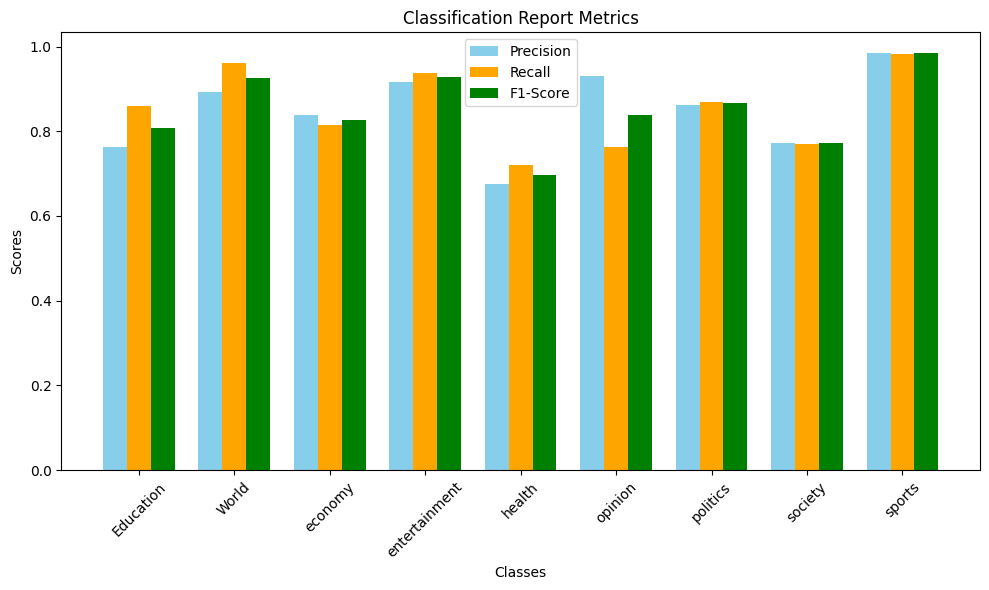

               precision    recall  f1-score   support

    Education       0.76      0.86      0.81       257
        World       0.89      0.96      0.93       896
      economy       0.84      0.81      0.83      1141
entertainment       0.92      0.94      0.93       651
       health       0.68      0.72      0.70       368
      opinion       0.93      0.76      0.84       624
     politics       0.86      0.87      0.87      1105
      society       0.77      0.77      0.77       935
       sports       0.98      0.98      0.98      1081

     accuracy                           0.87      7058
    macro avg       0.85      0.85      0.85      7058
 weighted avg       0.87      0.87      0.86      7058



In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predictions and true labels
# y_pred = model.predict(test_dataset)
# y_pred_labels = np.argmax(y_pred, axis=1)

# Get unique labels in y_test and y_pred_labels
unique_labels = np.unique(np.concatenate((y_test, y_pred_labels)))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels, labels=unique_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
            xticklabels=label_encoder.classes_[unique_labels].astype(str), # Use unique labels for target names
            yticklabels=label_encoder.classes_[unique_labels].astype(str))  # Use unique labels for target names
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(
    y_test, y_pred_labels,
    target_names=label_encoder.classes_[unique_labels].astype(str),
    labels=unique_labels,
    output_dict=True  # Get the report as a dictionary
)

# Extract metrics for each class
class_names = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
precision = [report[cls]['precision'] for cls in class_names]
recall = [report[cls]['recall'] for cls in class_names]
f1_score = [report[cls]['f1-score'] for cls in class_names]

# Create a bar plot for Precision, Recall, and F1-Score
x = np.arange(len(class_names))  # Label positions
width = 0.25  # Bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x, recall, width, label='Recall', color='orange')
plt.bar(x + width, f1_score, width, label='F1-Score', color='green')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

# Print the classification report
print(classification_report(
    y_test, y_pred_labels,
    target_names=label_encoder.classes_[unique_labels].astype(str),
    labels=unique_labels
))


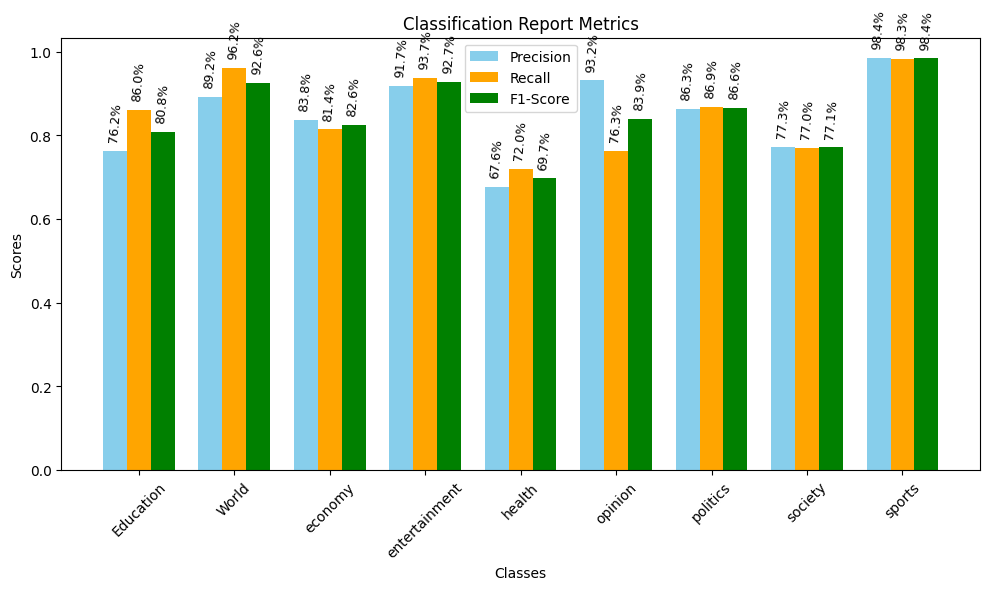

In [38]:
# Create a bar plot for Precision, Recall, and F1-Score
x = np.arange(len(class_names))  # Label positions
width = 0.25  # Bar width

plt.figure(figsize=(10, 6))
precision_bars = plt.bar(x - width, precision, width, label='Precision', color='skyblue')
recall_bars = plt.bar(x, recall, width, label='Recall', color='orange')
f1_score_bars = plt.bar(x + width, f1_score, width, label='F1-Score', color='green')

# Add percentages on top of each bar
for bars, metric in zip([precision_bars, recall_bars, f1_score_bars], [precision, recall, f1_score]):
    for bar, value in zip(bars, metric):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,  # Position: center and slightly above the bar
                 f'{value:.1%}', ha='center', va='bottom', fontsize=9,rotation=85)  # Format as percentage

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.94')

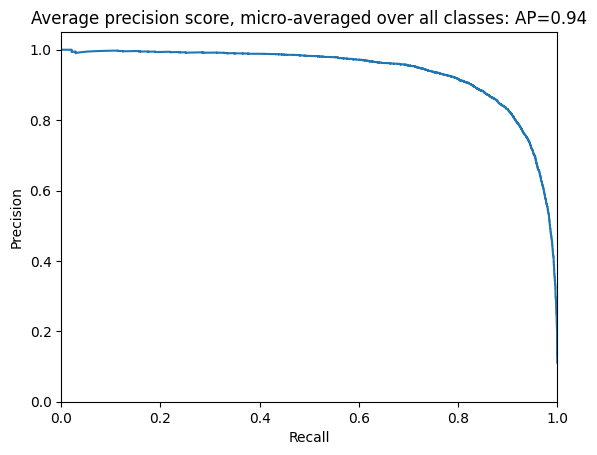

In [39]:
# Precision-Recall Curve for Multiclass Classification
from sklearn.metrics import average_precision_score # Import the function
from sklearn.preprocessing import label_binarize # Import label_binarize

# y_test is already in the correct format (class labels as integers)
# but we need to binarize it for multiclass precision-recall curve
y_test_bin = label_binarize(y_test, classes=range(num_classes))

# Iterate over each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        y_test_bin[:, i], y_pred[:, i] # Use binarized y_test
    )
    average_precision[i] = average_precision_score(
        y_test_bin[:, i], y_pred[:, i] # Use binarized y_test
    )

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_bin.ravel(), y_pred.ravel() # Use binarized y_test
)
average_precision["micro"] = average_precision_score(y_test_bin, y_pred, average="micro")

# Plot the micro-averaged Precision-Recall curve
plt.figure()
plt.step(recall["micro"], precision["micro"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    "Average precision score, micro-averaged over all classes: AP={0:0.2f}".format(
        average_precision["micro"]
    )
)

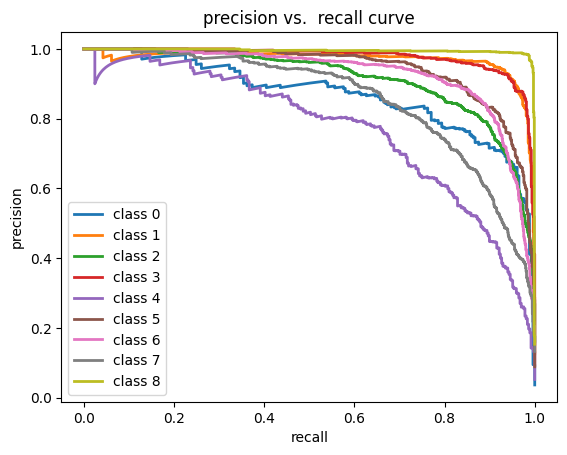

In [40]:
# @title
# Precision-Recall Curve for Multiclass Classification

# Iterate over each class
precision = dict()
recall = dict()
for i in range(num_classes): # num_classes is the number of classes in your dataset
    # Convert y_test to a NumPy array to ensure element-wise comparison
    y_test_array = np.array(y_test)
    precision[i], recall[i], _ = precision_recall_curve((y_test_array == i).astype(int), y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs.  recall curve")
plt.show()

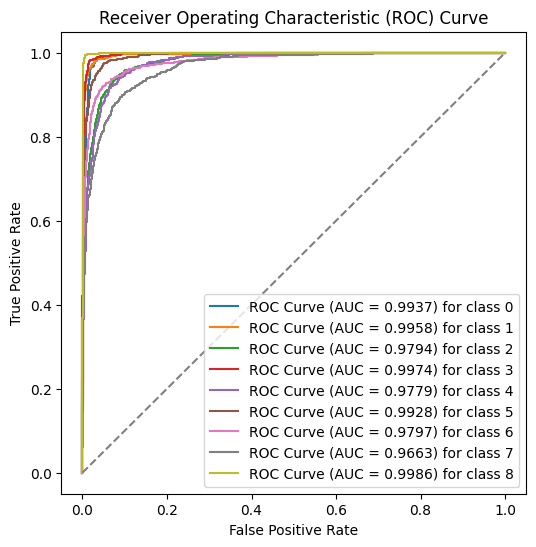

In [41]:
# ROC Curve for multiclass classification

# Binarize the output
y_test_binary = label_binarize(y_test, classes=range(num_classes)) # Change here

# Iterate over each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=plt.cm.tab10(i),
             label=f'ROC Curve (AUC = {roc_auc[i]:.4f}) for class {i}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
     

In [42]:
import pickle  # Add this line

# Save the model
model.save('./kaggle/working/my_trained_model')

# Save training history
with open('./kaggle/working/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)